Name: Lim Yu Yang Ian

Class: DAAA/FT/2A/02

Admin No: 2201874

___ 

# Importing modules

___

In [39]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import seaborn as sns
import warnings
from itertools import product
from pathlib import Path

# Metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import mean_squared_error

# Models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima

# EDA + Model Selection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests, pacf, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from statsmodels.tsa.statespace.tools import diff

# Pickle Library = Saving Models 
import pickle

___
# Set Up
___

In [3]:
default = (10, 5)
sns.set_style("darkgrid")

In [4]:
df = pd.read_csv("../ST1511-CA2-dataset/Energy Consumption Dataset.csv")
df.head()

,DATE,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
0,1/1/1990,18.0,725.1,548.8
1,1/2/1990,15.8,706.7,640.7
2,1/3/1990,17.3,624.5,511.1
3,1/4/1990,18.9,574.7,515.3
4,1/5/1990,22.0,553.2,488.4


___
# EDA
___

Setting up a copy to use for eda purposes

In [5]:
df_eda = df.copy()

In [6]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATE                           397 non-null    object 
 1   Gas Consumption (tons)         397 non-null    float64
 2   Electricity Consumption (MWh)  397 non-null    float64
 3   Water Consumption (tons)       397 non-null    float64
dtypes: float64(3), object(1)
memory usage: 12.5+ KB


Date is an object type, thus we will need to turn it into a date dtype later. 

The other values that we will be predicting are all continuous float values. Thus we will not need to alter their values.

In [7]:
df_eda.shape

(397, 4)

In [8]:
df_eda.describe()

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
count,397.000000,397.000000,397.000000
mean,23.785139,888.472544,484.953652
std,4.903452,153.877594,133.908863
min,11.600000,553.200000,44.400000
25%,20.200000,771.100000,384.400000
50%,23.500000,897.800000,487.400000
75%,27.900000,1005.200000,580.200000
max,46.000000,1294.000000,811.000000


In [9]:
df_eda.isna().sum()

DATE                             0
Gas Consumption (tons)           0
Electricity Consumption (MWh)    0
Water Consumption (tons)         0
dtype: int64

There are no Null values, thus we will not need to do handling for it

As said on top, the date column is an object dtype. Thus we will create a new "Date" column below of the correct dtype and drop the original "DATE" column

In [10]:
df['Date'] = pd.to_datetime(df['DATE'], format="%d/%m/%Y")
df = df.drop(["DATE"], axis=1)
df.set_index('Date', inplace=True)
display(df)

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
Date,,,
1990-01-01,18.0,725.1,548.8
1990-02-01,15.8,706.7,640.7
1990-03-01,17.3,624.5,511.1
1990-04-01,18.9,574.7,515.3
1990-05-01,22.0,553.2,488.4
...,...,...,...
2022-09-01,27.7,986.2,513.3
2022-10-01,31.8,936.1,373.1
2022-11-01,31.0,973.4,343.9


In [11]:
prof = ProfileReport(df_eda, explorative=True)

### Using a heatmap to compare correlation of each value

We are using Pearson's R correlation

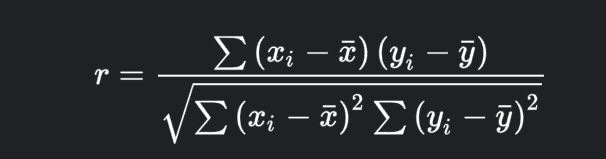

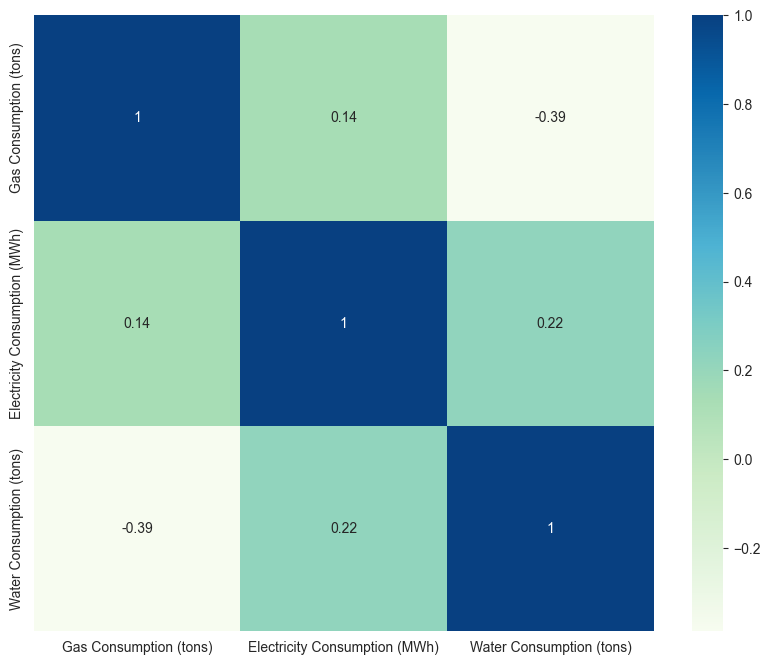

In [12]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="GnBu")
plt.show()

<Figure size 640x480 with 0 Axes>

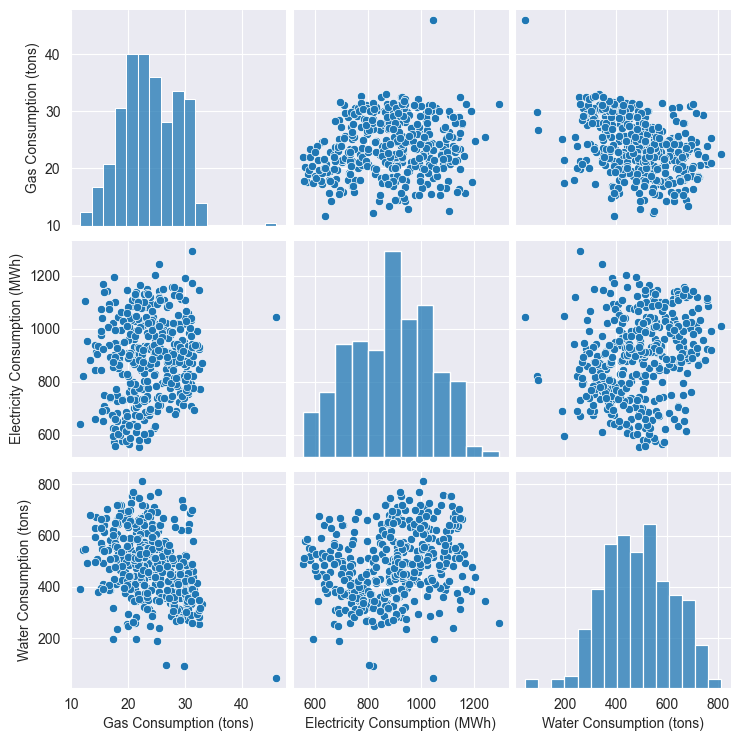

In [13]:
fig = plt.figure()
sns.pairplot(df)
plt.show()

### Observations:

We can observe that there are not much of a relationship between each type of consumption. All of them have very weak positive/ negative relationships

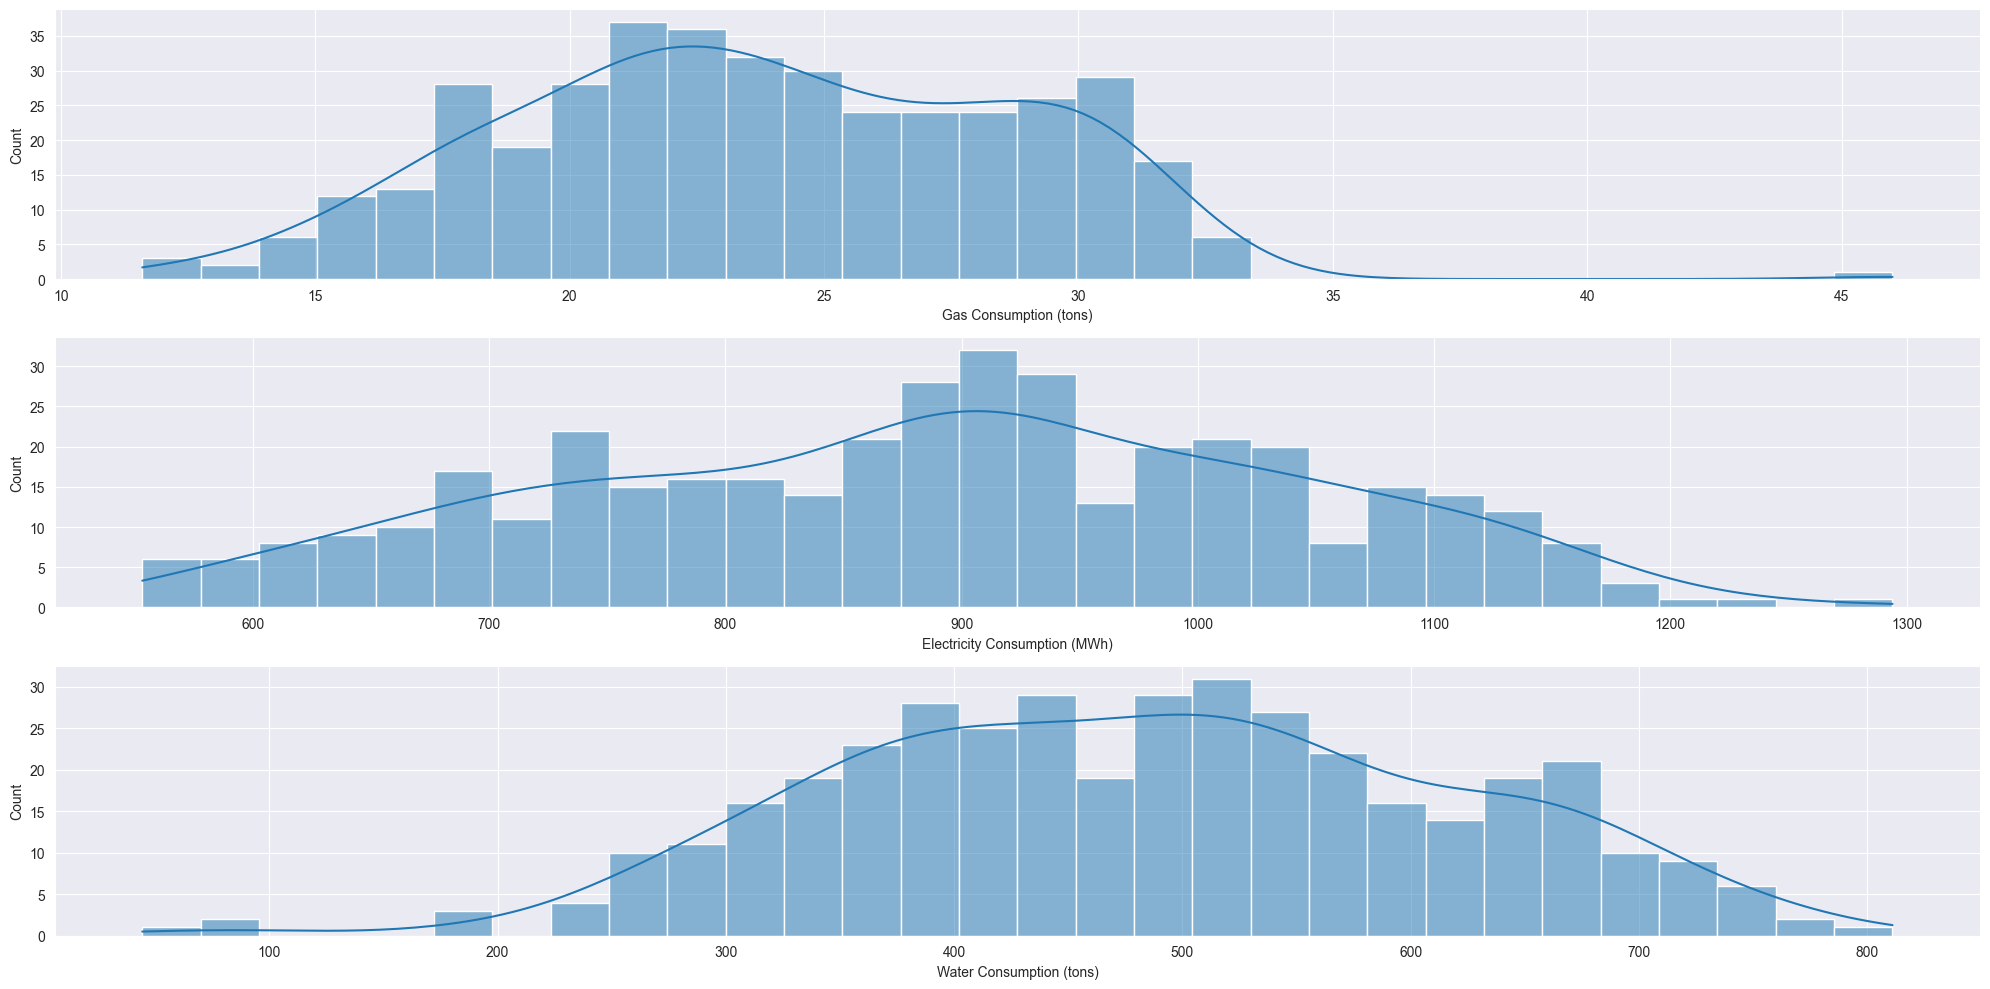

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10), tight_layout=True)

for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    sns.histplot(data=df, x=y_temp, bins=30, ax=ax[i], kde=True)

### Observations:

We can observe that Gas Consumption is skewed to the left.

We can observe that Electricity is normally distributed.

We can observe that Water Consumption is skewed to the right.

___
# Time Series Visualisation
___

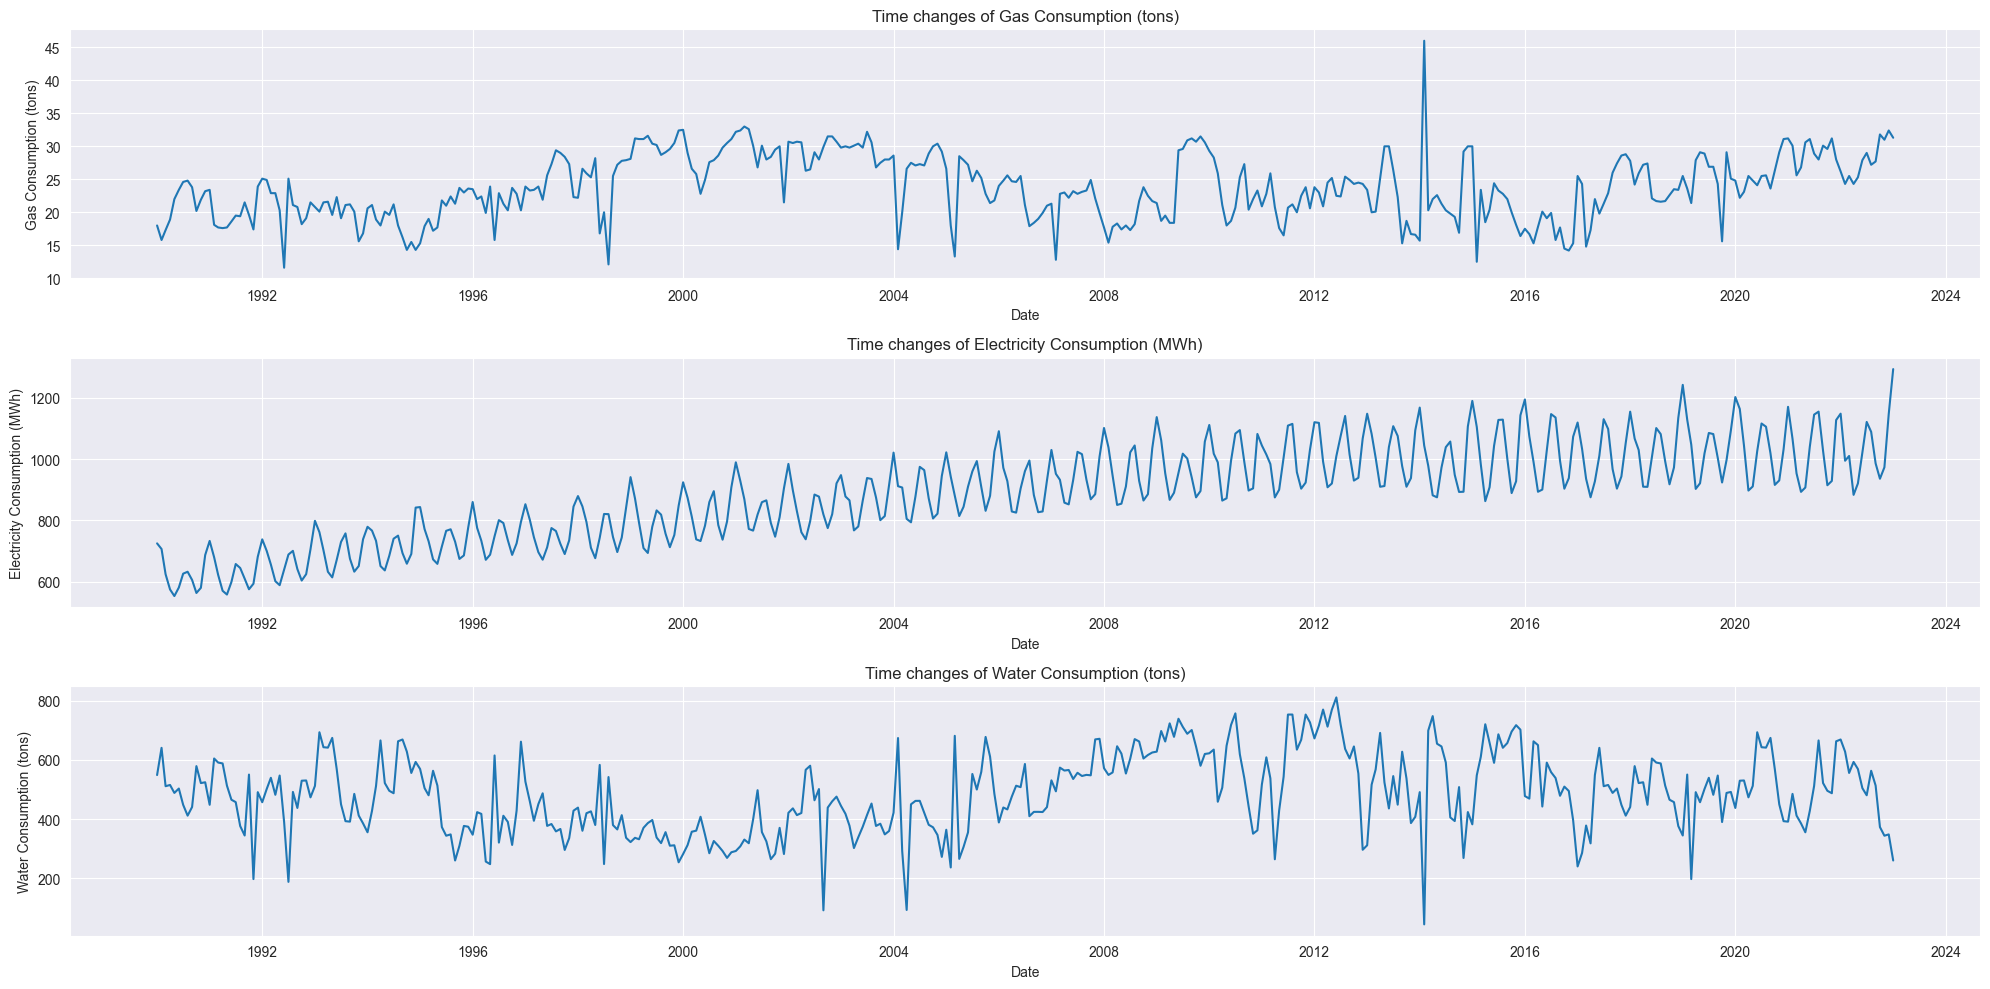

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10), tight_layout=True)
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    sns.lineplot(df[y_temp], ax=ax[i])
    ax[i].set_title("Time changes of " + y_temp)
    
plt.show()

### Observations:

#### Gas Consumption:

There are a lot of spikes which means that there is a very high variance in quantity of Gas Consumption. There is not much of a trend.

#### Electicity Comsumption

There is a pattern of a positive upward trend

#### Water Consumption

There are a lot of spikes which means that there is a very high variance in quantity of Water Consumption. There is not much of a trend.

___
# Seasonal Decomposition
___

Column: Gas Consumption (tons)
Seasonal Decomposition: 12


<Figure size 2000x1000 with 0 Axes>

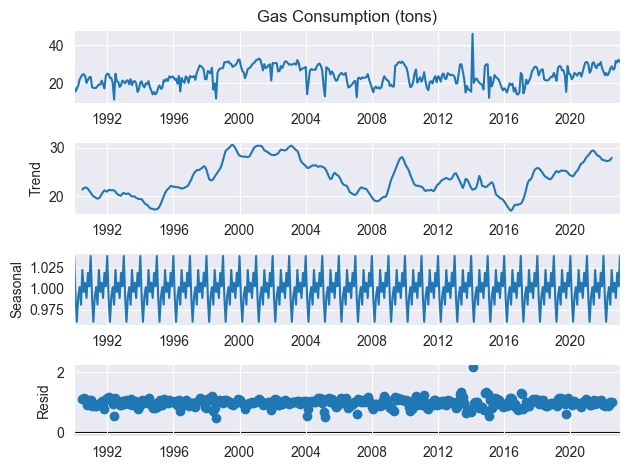

Column: Electricity Consumption (MWh)
Seasonal Decomposition: 12


<Figure size 2000x1000 with 0 Axes>

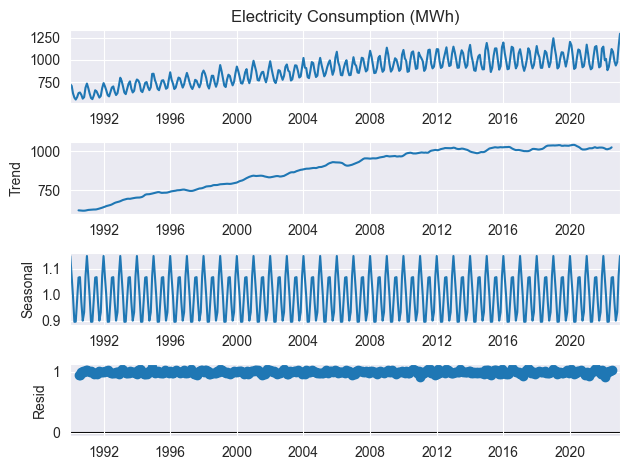

Column: Water Consumption (tons)
Seasonal Decomposition: 12


<Figure size 2000x1000 with 0 Axes>

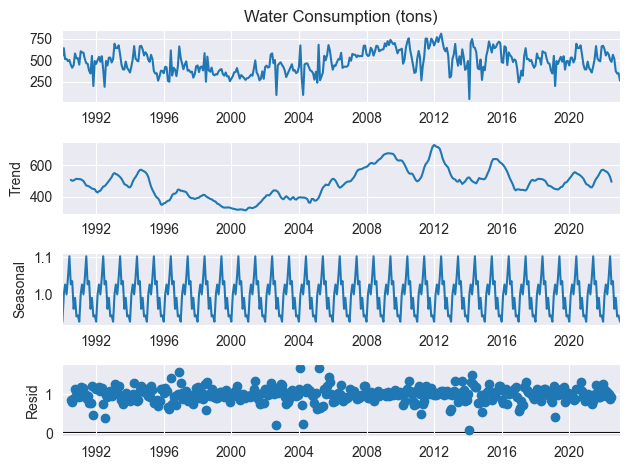

In [16]:
for i in df.columns:
    decomp = seasonal_decompose(df[i], model="multiplicative")

    fig = plt.figure(figsize=(20, 10), tight_layout=True)

    print(f"Column: {i}")
    print(f"Seasonal Decomposition: {len(decomp.seasonal.drop_duplicates())}")

    decomp.plot()
    plt.show()

___
# Granger's Test for Causality
___

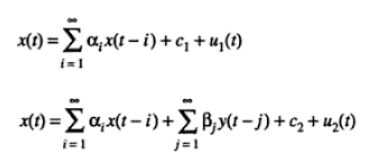

Granger's Test for causality helps me to assess whether changes in one time series can predict of cause changes in another time series. 

This allows me to potentially identify relationships and dependencies between my variables.

In [31]:
maxlag = 12
test = "ssr_chi2test"

g_matrix = pd.DataFrame(
    np.zeros((len(df.columns), len(df.columns))),
    columns=df.columns,
    index=df.columns,
)
for c in g_matrix.columns:
    for r in g_matrix.index:
        test_result = grangercausalitytests(
            df[[r, c]], maxlag=maxlag, verbose=False
        )
        p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
        min_p_value = np.min(p_values)
        g_matrix.loc[r, c] = min_p_value
g_matrix.columns = [var + "_x" for var in df.columns]
g_matrix.index = [var + "_y" for var in df.columns]

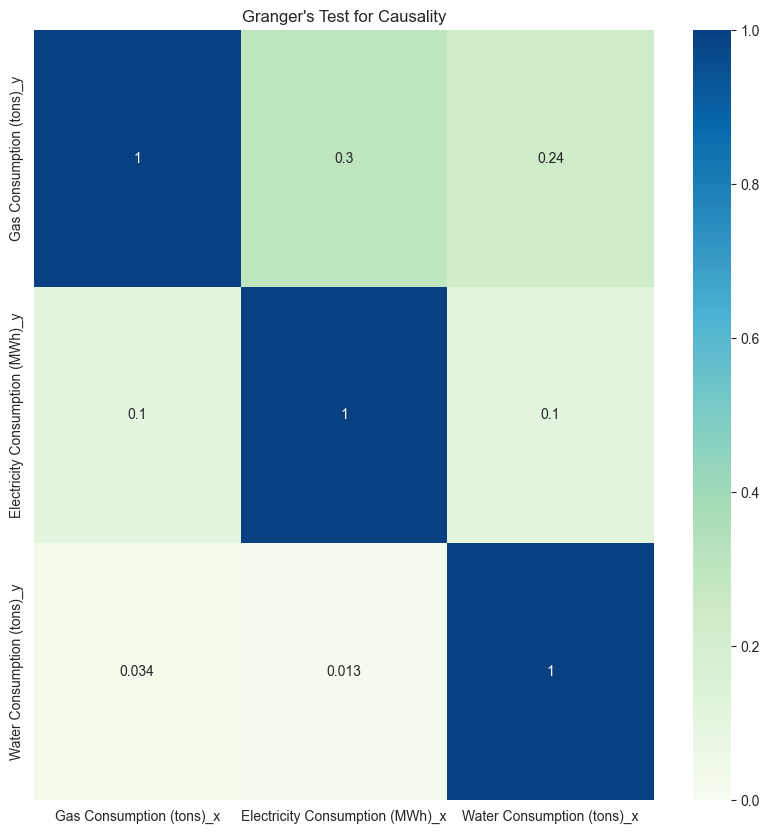

In [18]:
plt.figure(figsize=(10, 10))
sns.heatmap(g_matrix, annot=True, cmap="GnBu", vmin=0, vmax=1)
plt.title("Granger's Test for Causality")
plt.show()

### Observations:

The granger test score for Water against Gas and Electricity is less thatn the significant value of 0.05.

This would mean there is a granger casual relationship between Gas Consumption and Water Consumption. And Electricity Consumption and Water Consumption.

# Covariance

In [19]:
X1 = df.iloc[:len(df)//2, 0]
X2 = df.iloc[len(df)//2:, 0]
print(f'group 1 mean = {X1.mean():.2f}, group 2 mean = {X1.mean():.2f}, \ngroup 1 variance = {X1.var():.2f}, group 2 variance = {X2.var():.2f}')

group 1 mean = 24.28, group 2 mean = 24.28, 
group 1 variance = 24.48, group 2 variance = 23.23


___
# P-Value
___

I will be using the Augmented Dickey Fuller Test to obtain the P-Values.

The ADF Test is a statistical test used to determine whether a unit root is present in a time serires dataset. 



The below are my hypothesis for the ADF Test

Let H0 be Data is not stationary

Let H1 be Data is stationary

In [20]:
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    result = adfuller(df[y_temp])
    print(y_temp, 'p-value: %f' % result[1])

Gas Consumption (tons) p-value: 0.010811
Electricity Consumption (MWh) p-value: 0.186218
Water Consumption (tons) p-value: 0.000090


### Observations

Since the P-value of Gas Consumption and Water Consumption is less that 0.05, we reject the null hypothesis. Thus the data is stationary

Since the P-value of Electricity is more than 0.05, we accept the null hypothesis. Thus the data is not stationary and action needs to be taken.

___
# Differencing
___

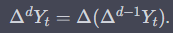

As the Electricity Consumption data is not stationary, I will need to do order differencing on it.

Below I have written code to automatically differenciate the data until its ADF Test value is below 0.05.

Gas Consumption (tons) Original p-value: 0.010811



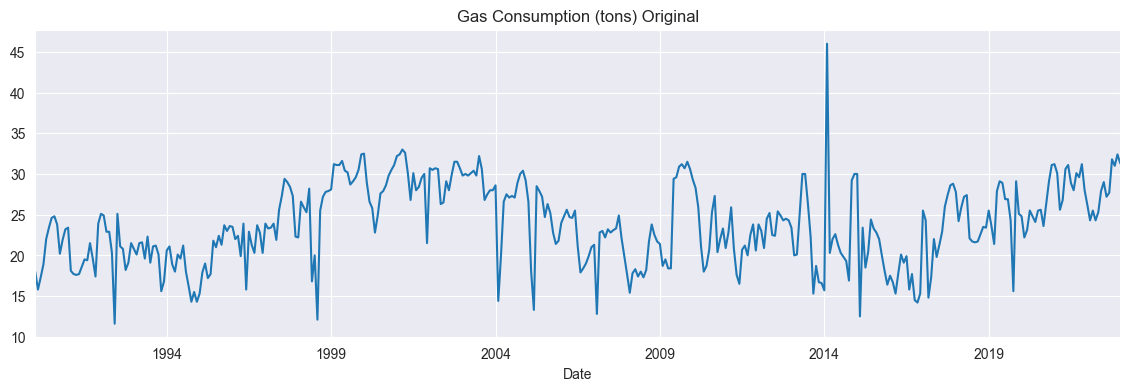

Electricity Consumption (MWh) Original p-value: 0.186218
Electricity Consumption (MWh) After differencing p-value (1 Order): 0.000000



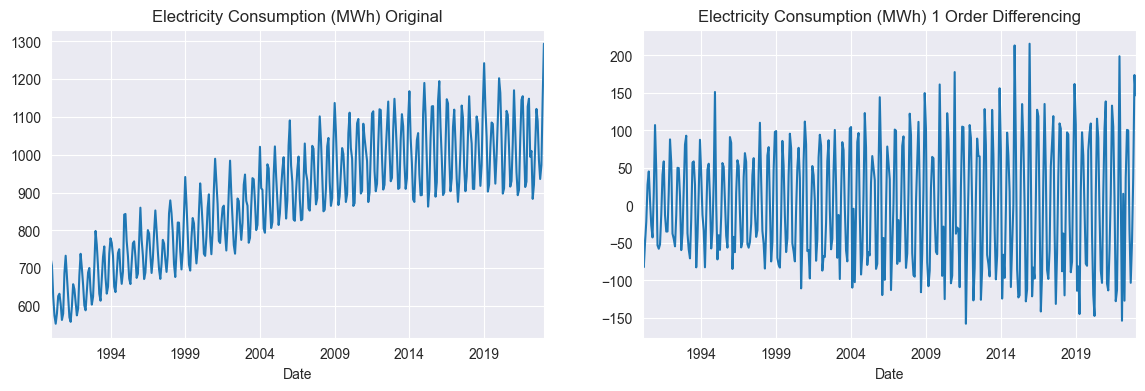

Water Consumption (tons) Original p-value: 0.000090



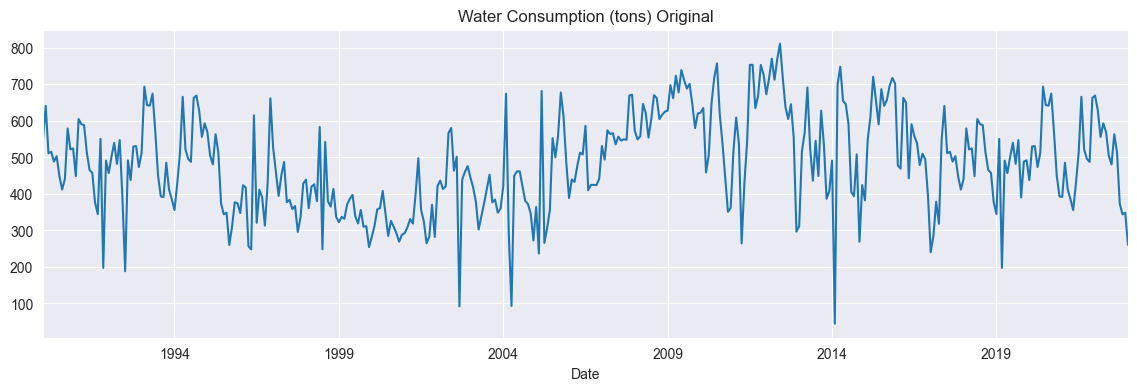

In [21]:
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    result = adfuller(df[y_temp])
    print(y_temp, 'Original p-value: %f' % result[1])

    count = 0
    while result[1] >= 0.05:
        count += 1
        df_diff = diff(df[y_temp], k_diff=count)

        result = adfuller(df_diff)
        print(y_temp, f'After differencing p-value ({count} Order): %f' % result[1])
    
    print()

    if count >= 1:
        fig, ax = plt.subplots(1, count + 1, figsize=(14, 4))
        df[y_temp].plot(ax=ax[0])
        ax[0].set_title(f'{y_temp} Original')

        for j in range(count):
            df_diff.plot(ax=ax[count])
            ax[count].set_title(f'{y_temp} {count} Order Differencing')
        plt.show()

    else:
        fig = plt.figure(figsize=(14, 4))
        df[y_temp].plot()
        plt.title(f'{y_temp} Original')
        plt.show()

    

### Observations
In a SARIMA model, I need to check if your time series is stationary or not. Using the above, I can identify whether each time series is stationary or not, and how high my k_diff value needs to be for it to be stationary. This will help me identify my differencing order (D) in the SARIMA model below.

Gas Consumption:

The original P-Value is less that 0.05, thus the Value of D would be 0

Electricity Consumption:

The P-Value is more than 0.05 before differencing, and it is below 0.05 after differencing with a k_diff value of 1, thus the Value of D would be 1

Water Consumption:

The original P-Value is less that 0.05, thus the Value of D would be 0

___
# Seasonal Decomposition
___

Seasonal Decomposition will give 3 outputs:
1. Trend
    - Represents the long-term movement or direction of the time series
2. Seasonality 
    - Captures the repeating patterns or cycles that occur
3. Residuals (Noise)
    - Represents the random or irregular fluctuations that remain after removing the trend and seasonality


The seasonal_decompose() function can take in two types of models:
- Additive
    - Linear
    - For Stationary Datasets
- Multiplicative
    - Non-Linear
    - For Non Stationary Datasets

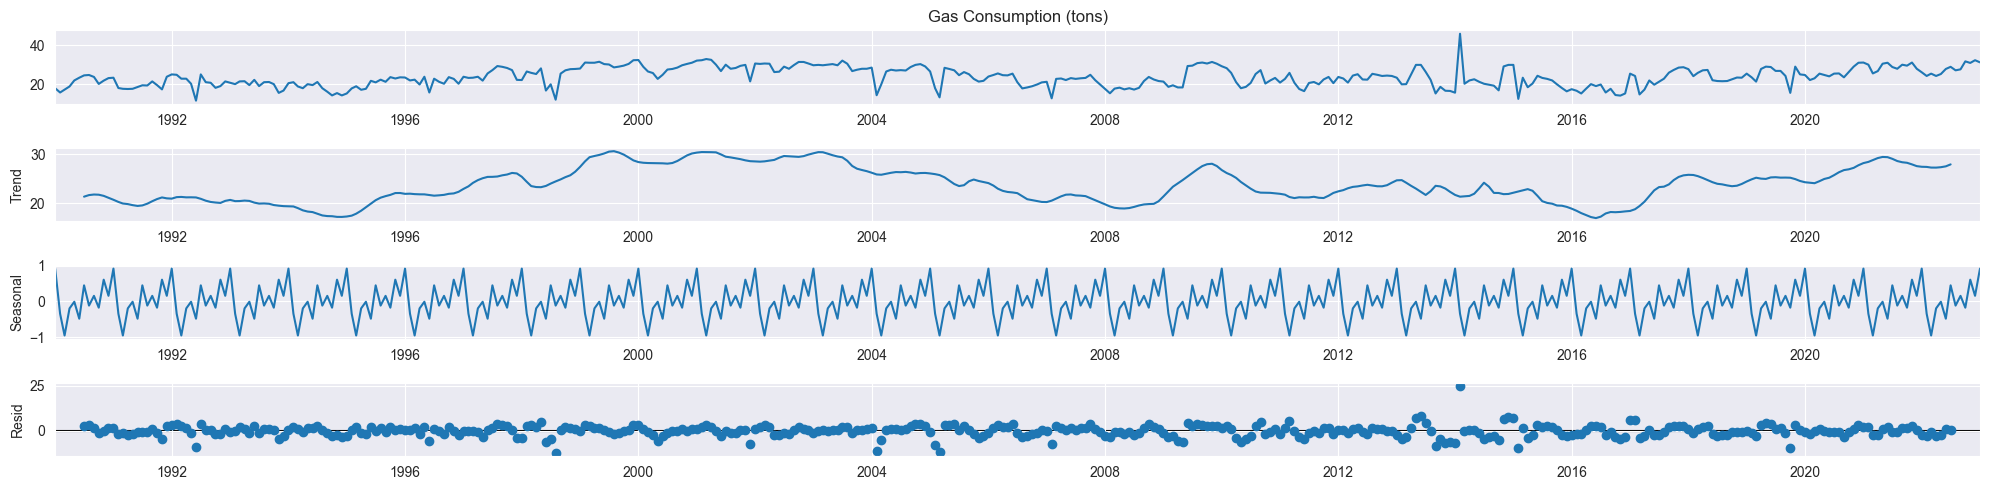

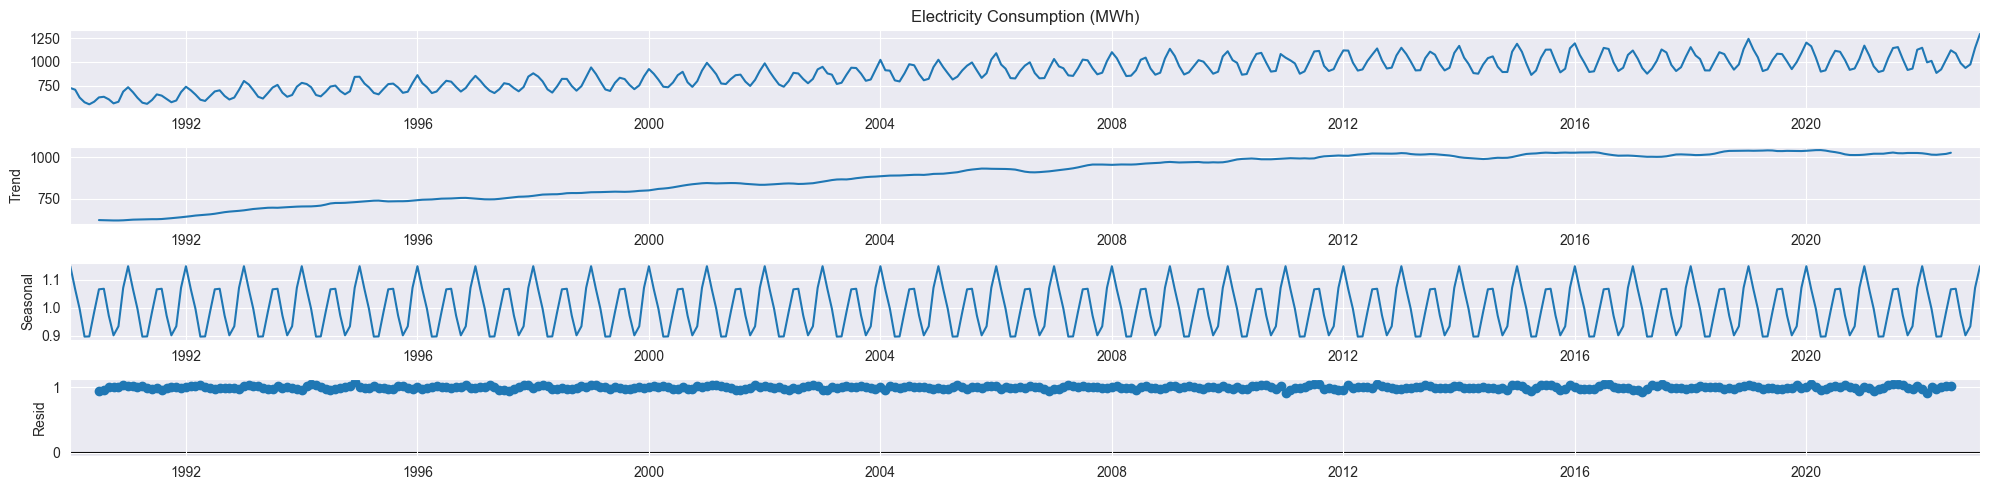

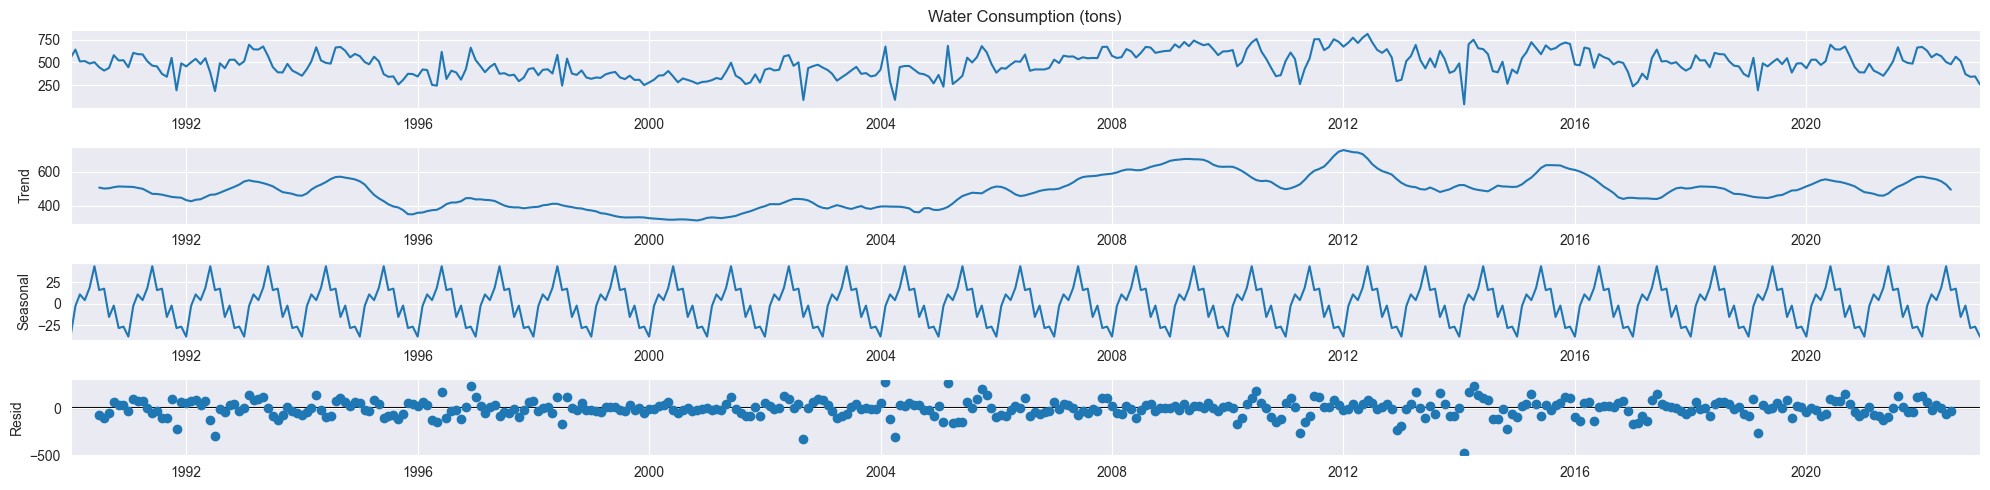

In [36]:
# Gas Consumption Seasonal Decomposition, Stationary Data
plt.rcParams['figure.figsize'] = (20, 5)
gas_SeasonalDecompose = seasonal_decompose(df['Gas Consumption (tons)'], model = 'additive')
gas_SeasonalDecompose.plot()
plt.show()

# Electricity Consumption Seasonal Decomposition, Non-Stationary Data
electricity_SeasonalDecompose = seasonal_decompose(df['Electricity Consumption (MWh)'], model = 'multiplicative')
electricity_SeasonalDecompose.plot()
plt.show()

# Water Consumption Seasonal Decomposition, Stationary Data
water_SeasonalDecompose = seasonal_decompose(df['Water Consumption (tons)'], model = 'additive')
water_SeasonalDecompose.plot()
plt.show()

### Observations

- Gas Consumption
    - No trend
    - Strong Seasonality
    - Residual follows trend line with little outliers
- Electricity Consumption
    - Positive Linear Trend
    - Very Strong Seasonality
    - Residual does not follow trend line, and is far above it
- Water Consumption
    - No trend
    - Strong Seasonality
    - Residual roughly follows the trend line, with many outliers

___
# Partial/ Autocorrelation Function Analysis
___

I would like to identify two things from the following graphs.
1. Order
    - p: (Autoregressive Order) represents the number of lagged values of the dependent variable. It indicates how many past observations of the series are used to predict the current value.
    - d: (Differencing Order) represents the number of times the time series is differenced to achieve stationarity.
    - q: (Moving Average Order) represents the number of lagged forecast errors.
2. Seasonal Order (p, d, q, s)
    - p: (Seasonal Autoregressive Order) Similar to non-seasonal AR component. However this captures the relationship between the current value and its past values, but for seasonal lags.
    - d: (Seasonal Differencing Order) Similar to non-seasonal differencing, except this one helps to remove the seasonal trends and fluctuations.
    - q: (Seasonal Moving Average Order) Similar to non-seasonal MA component. However this one captures the relationship between current values and forecast error in seasonal lags.
    - s: (Seasonal Periodicity) Specifies the number of time periods per season in the data. It corresponds to the length of the seasonal pattern I would like to capture.



c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


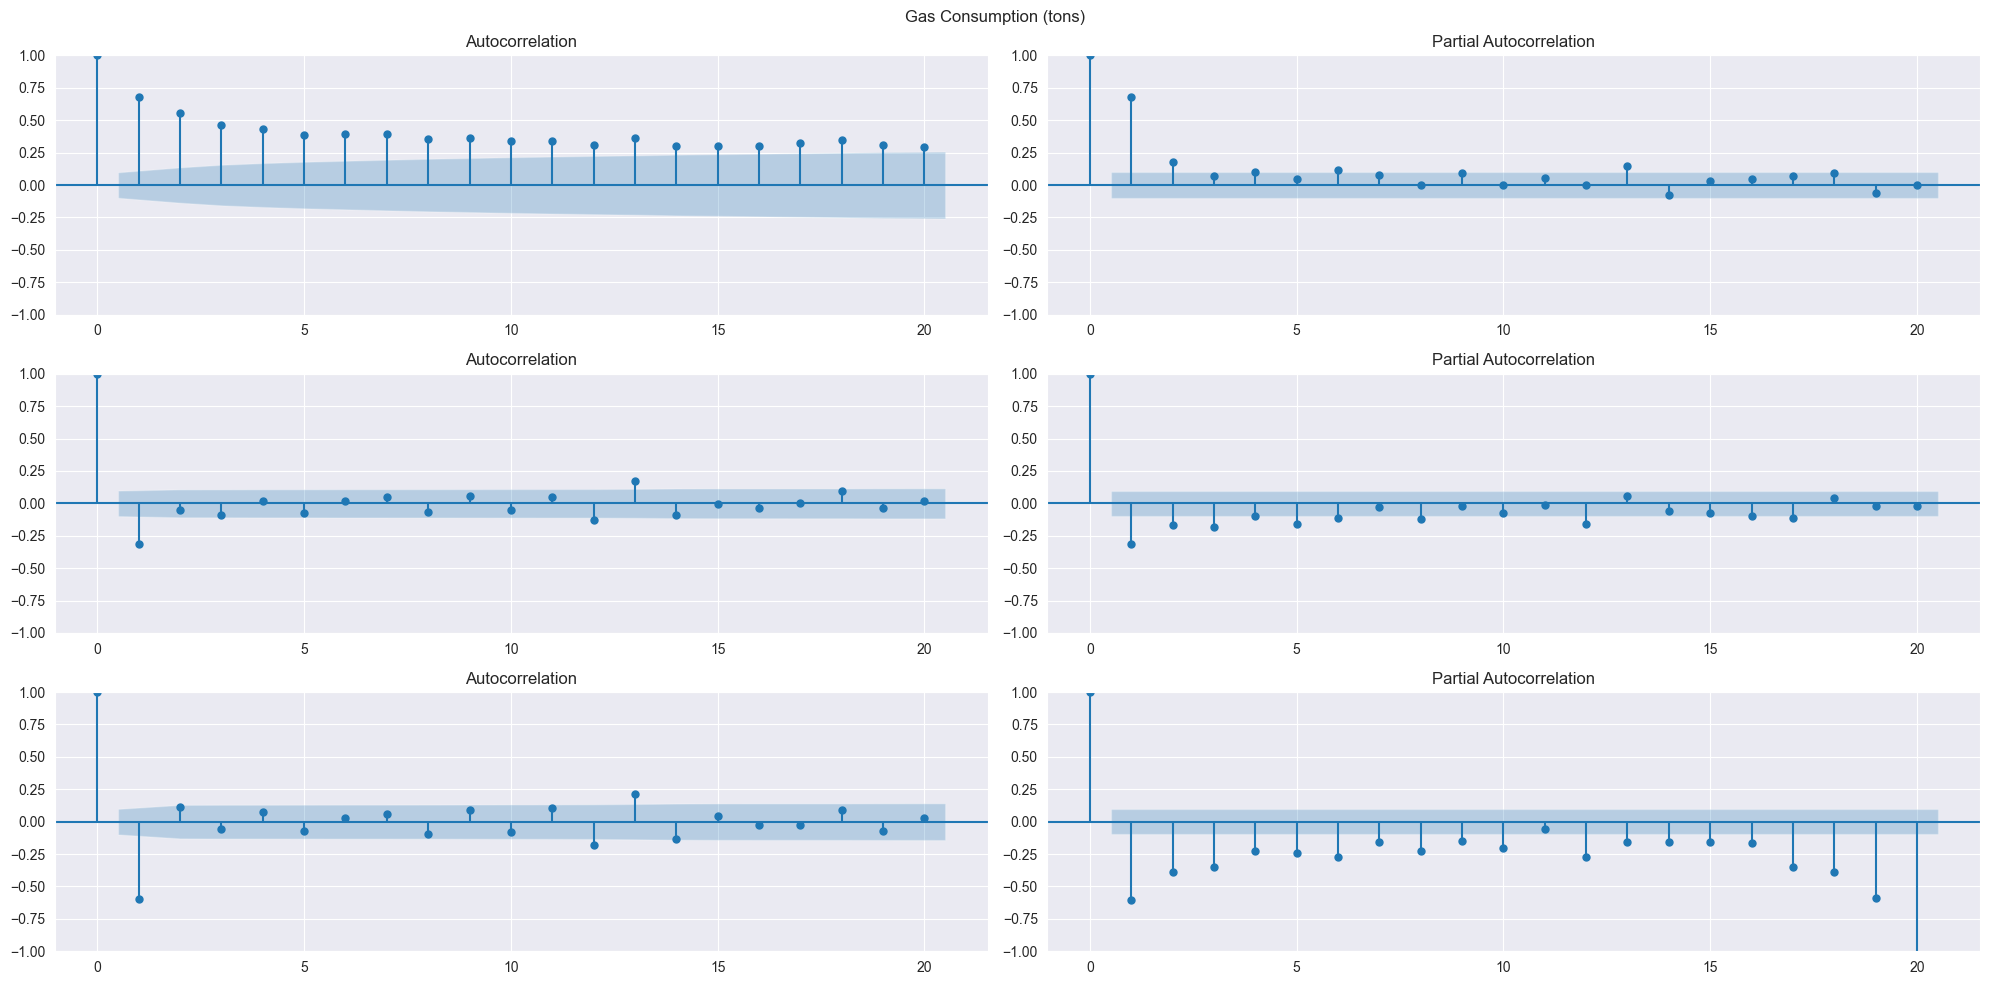

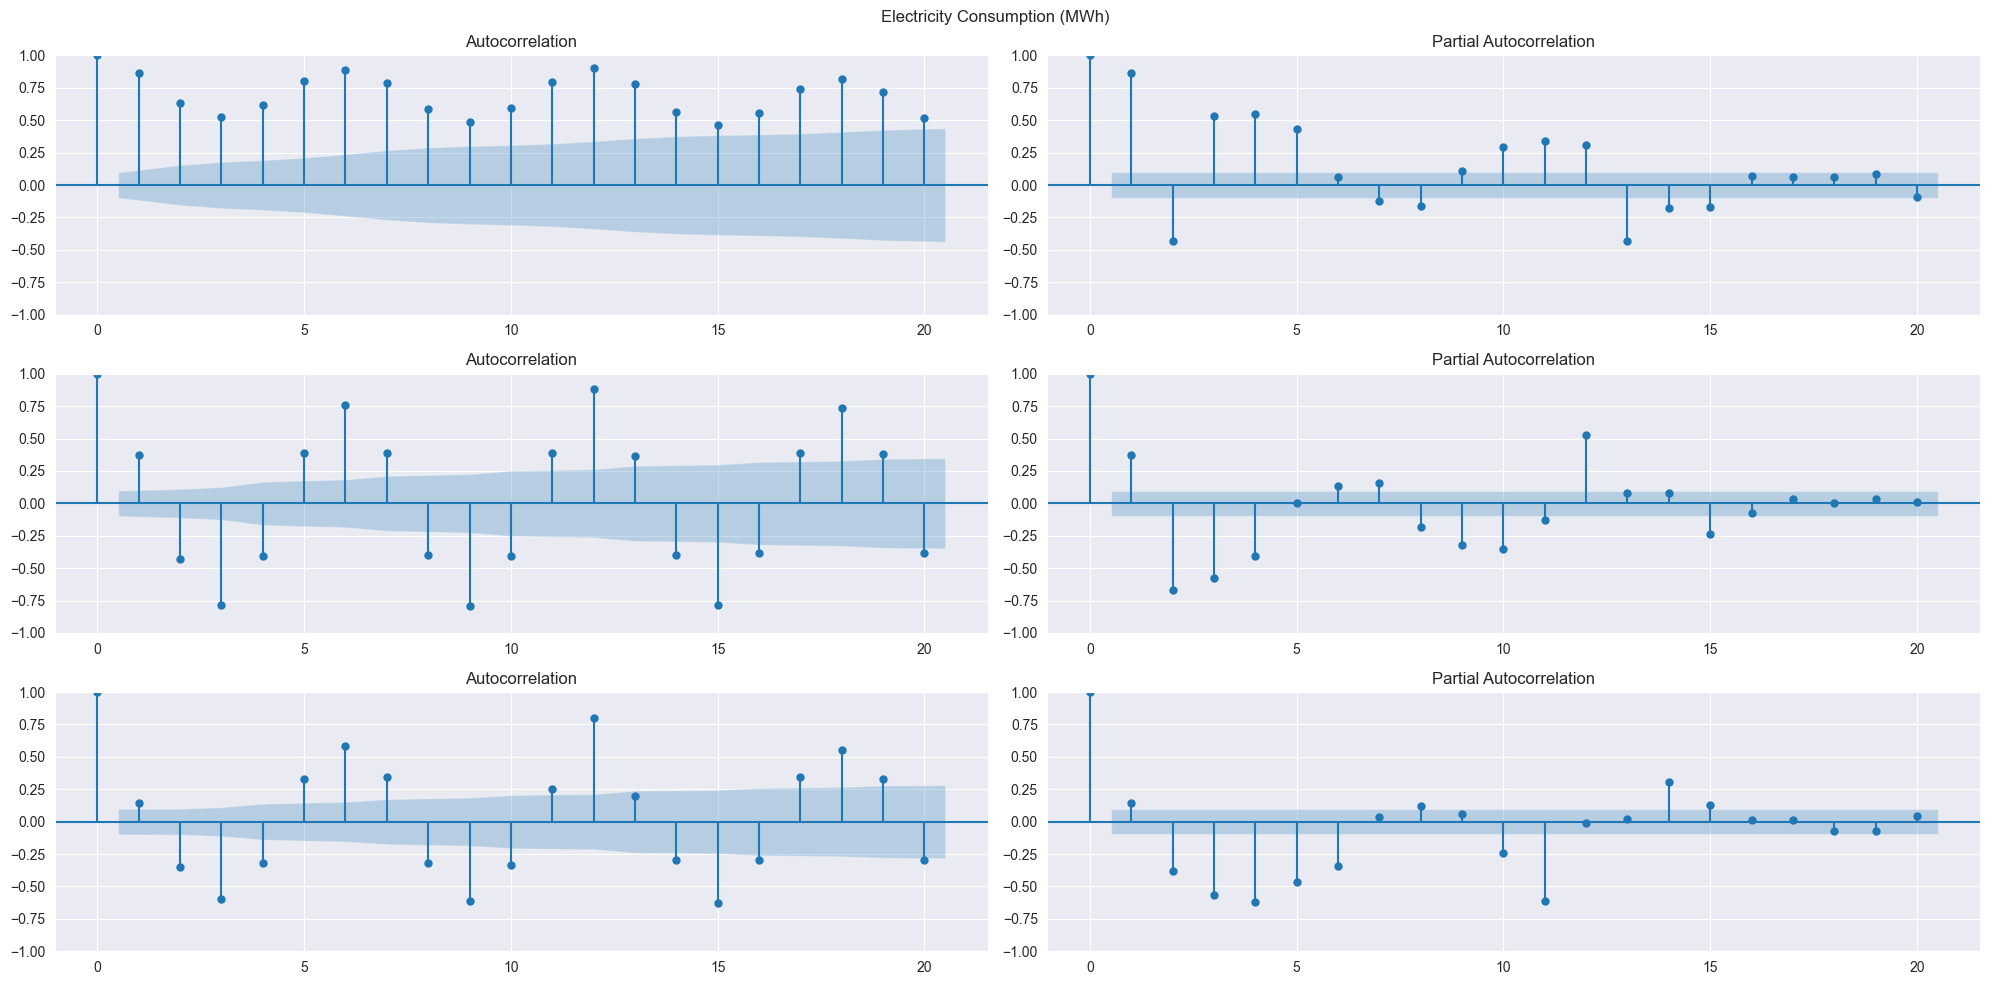

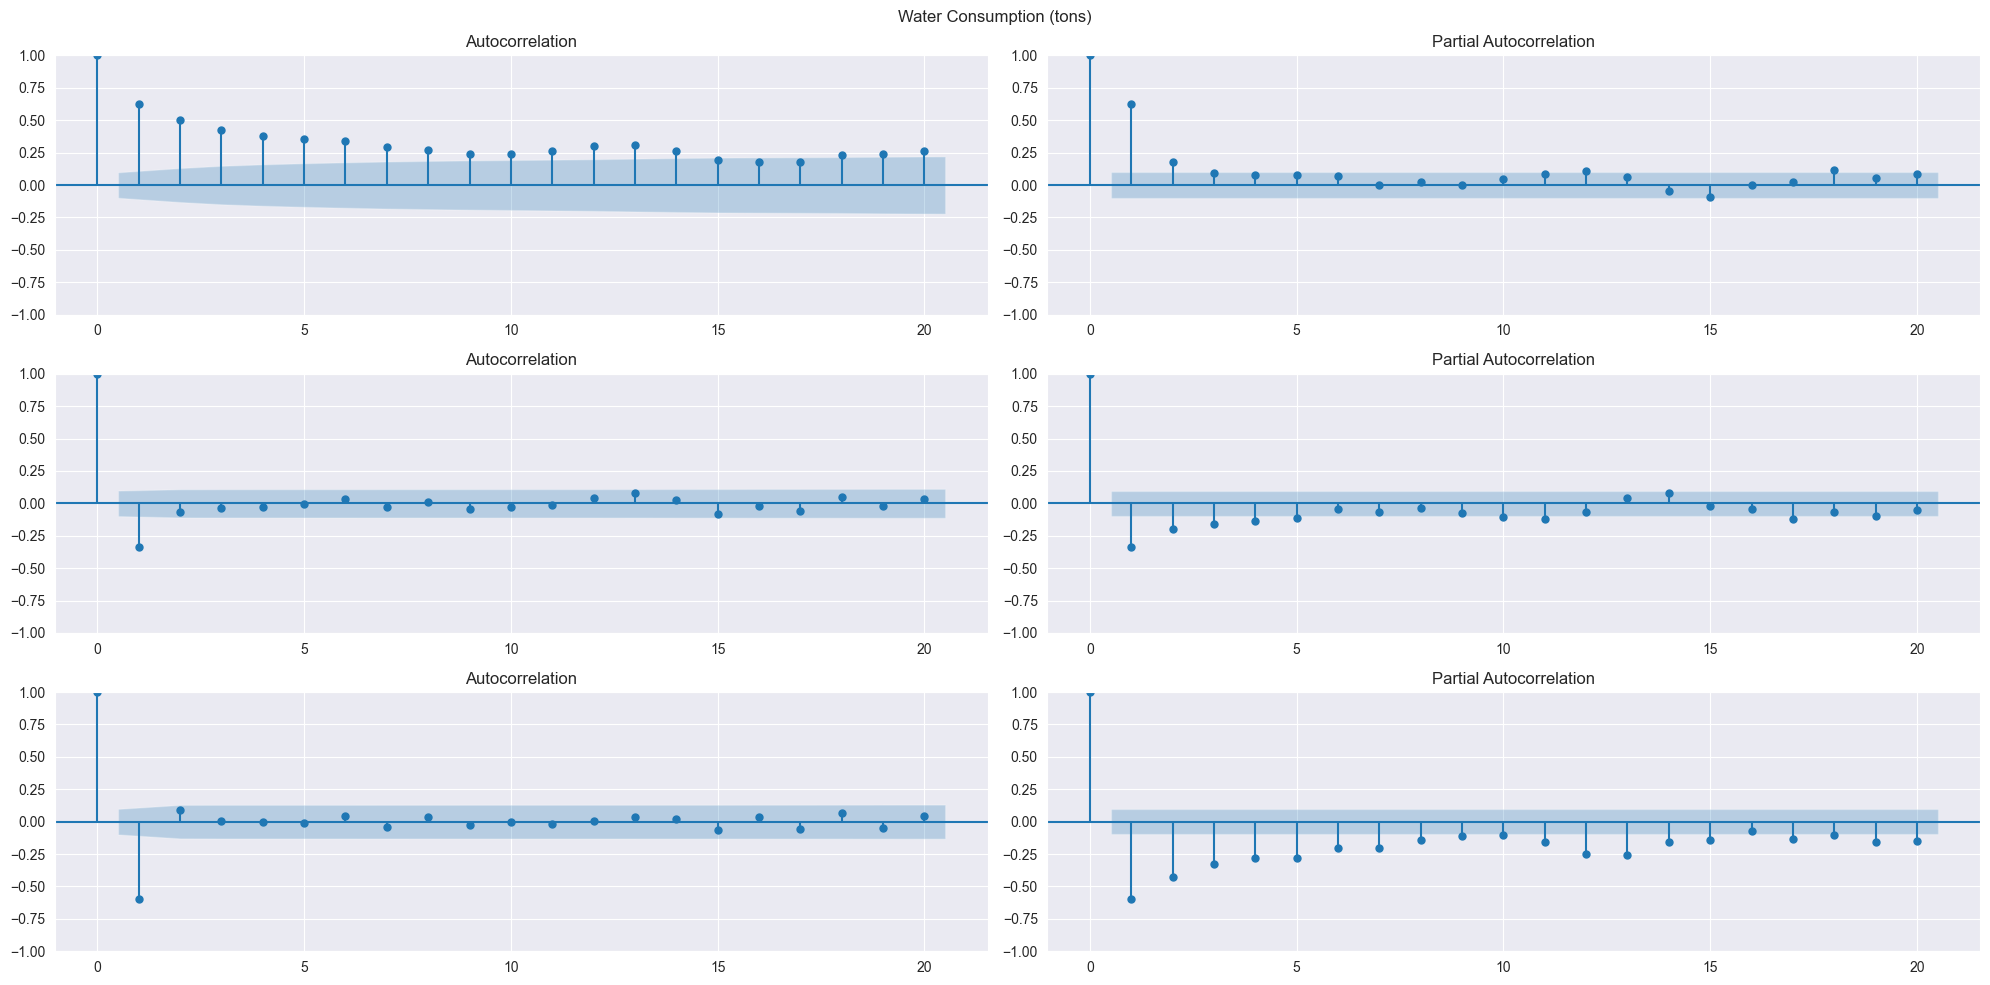

In [22]:
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    fig, ax = plt.subplots(3, 2, figsize=(20, 10), tight_layout=True)
    plot_acf(df[y_temp], lags=20, ax=ax[0,0])
    plot_pacf(df[y_temp], lags=20, ax=ax[0,1])

    plot_acf(df[y_temp].diff().dropna(), lags=20, ax=ax[1,0])
    plot_pacf(df[y_temp].diff().dropna(), lags=20, ax=ax[1,1])

    plot_acf(df[y_temp].diff().diff().dropna(), lags=20, ax=ax[2,0])
    plot_pacf(df[y_temp].diff().diff().dropna(), lags=20, ax=ax[2,1])

    fig.suptitle(y_temp)
    plt.show()

### Observations:

Geometric Decay = GD

- Gas:
    - ACF Shows GD at 0 order. 
    - PACF shows significant lags at 1 and 13. 1 is the most significant lag.
    - Order (1, 0, 0)X(No seasonality)

- Electricity:
    - ACF Shows Sine GD at 1st order. 
    - PACF shows significant lags at 2 and 12. Both are similar
    - Order (1, 1, 1) X (1, 1, 0, 3)


- Water:
    - ACF Shows GD at 0 order.
    - PACF shows significant lag at 1. 
    - Order (1, 0, 0)X(No seasonality)

# Splitting Data

In [23]:
trainSize = int(len(df) * 0.8)
y_train, y_test = df[:trainSize], df[trainSize:]
print(f"y train: {y_train.shape}")
print(f"y test: {y_test.shape}")

y train: (317, 3)
y test: (80, 3)


In [24]:
y_train_dic = {}
y_test_dic = {}
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    y_train_dic[y_temp], y_test_dic[y_temp] = y_train[y_temp], y_test[y_temp]

# ARIMA Baseline

                                 SARIMAX Results                                  
Dep. Variable:     Gas Consumption (tons)   No. Observations:                  317
Model:                     ARIMA(1, 1, 1)   Log Likelihood                -851.861
Date:                    Wed, 09 Aug 2023   AIC                           1709.721
Time:                            23:04:12   BIC                           1720.989
Sample:                        01-01-1990   HQIC                          1714.223
                             - 05-01-2016                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4200      0.043      9.873      0.000       0.337       0.503
ma.L1         -0.9052      0.036    -24.899      0.000      -0.976      -0.834
sigma2        12.815

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


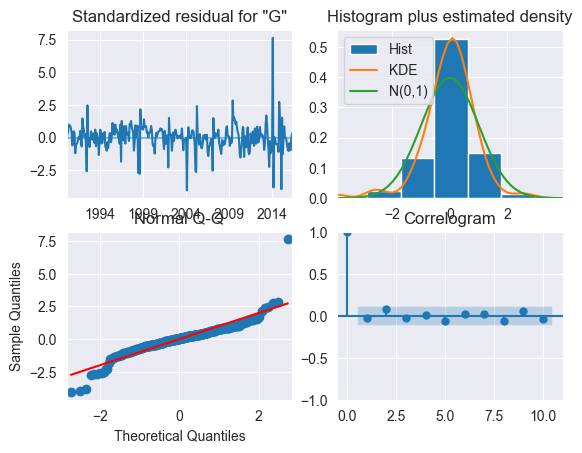

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:     Electricity Consumption (MWh)   No. Observations:                  317
Model:                            ARIMA(1, 1, 1)   Log Likelihood               -1750.289
Date:                           Wed, 09 Aug 2023   AIC                           3506.578
Time:                                   23:04:13   BIC                           3517.845
Sample:                               01-01-1990   HQIC                          3511.079
                                    - 05-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0470      0.101      0.466      0.641      -0.151       0.245
ma.L1          0.5738      0.075      7.696

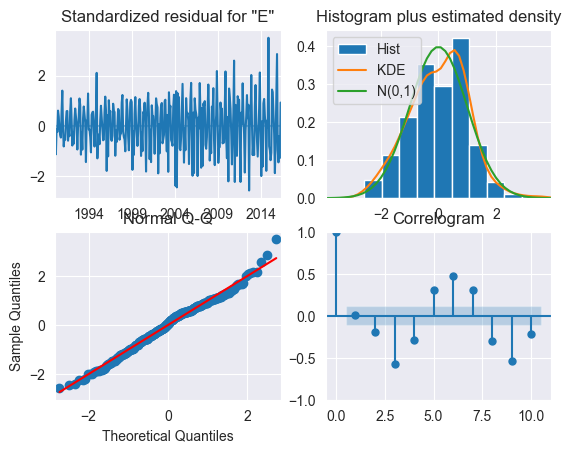

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                   
Dep. Variable:     Water Consumption (tons)   No. Observations:                  317
Model:                       ARIMA(1, 1, 1)   Log Likelihood               -1915.981
Date:                      Wed, 09 Aug 2023   AIC                           3837.961
Time:                              23:04:13   BIC                           3849.228
Sample:                          01-01-1990   HQIC                          3842.462
                               - 05-01-2016                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3952      0.050      7.891      0.000       0.297       0.493
ma.L1         -0.9167      0.026    -34.879      0.000      -0.968      -0.865
sigm

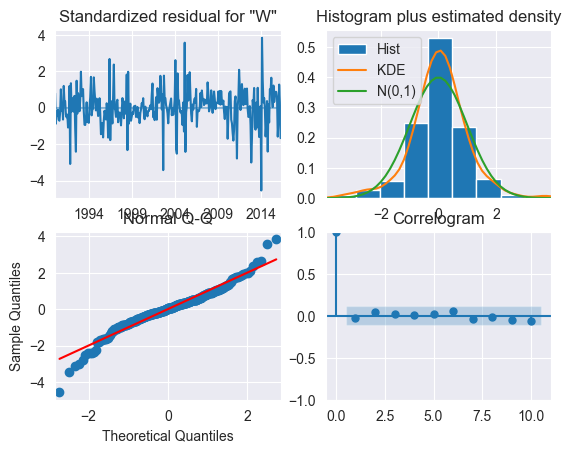

In [25]:
model_list = []
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    model_list.append(ARIMA(y_train_dic[y_temp], order=(1, 1, 1)).fit())
    print(model_list[i].summary())
    model_list[i].plot_diagnostics()
    plt.show()

# SARIMA

In [26]:
def model_cv(
    model, endog, order=(1, 1, 1), splits=3, seasonal_order=None, max_iter=1000
):
    valid_rmse = []
    valid_mape = []
    train_rmse = []
    train_mape = []
    model_aic = []
    model_bic = []
    time_series = TimeSeriesSplit(n_splits=splits)
    for train_index, test_index in time_series.split(endog):
        y_train, y_test = endog.iloc[train_index], endog.iloc[test_index]
        if seasonal_order is None:
            model_fit = model(endog=y_train, order=order).fit(
                maxiter=max_iter, disp=False
            )
        else:
            model_fit = model(
                endog=y_train, seasonal_order=seasonal_order, order=order
            ).fit(maxiter=max_iter, disp=False)
        y_pred = model_fit.predict(
            start=y_test.index[0], end=y_test.index[-1]
        )
        valid_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        valid_mape.append(mean_absolute_percentage_error(y_test, y_pred))
        train_pred = model_fit.predict(
            start=y_train.index[0], end=y_train.index[-1]
        )
        train_rmse.append(mean_squared_error(y_train, train_pred, squared=False))
        train_mape.append(mean_absolute_percentage_error(y_train, train_pred))
        model_aic.append(model_fit.aic)
        model_bic.append(model_fit.bic)
    return (
        pd.Series(
            {
                "train_rmse": np.mean(train_rmse),
                "train_rmse_std": np.std(train_rmse),
                "valid_rmse": np.mean(valid_rmse),
                "valid_rmse_std": np.std(valid_rmse),
                "train_mape": np.mean(train_mape),
                "valid_mape": np.mean(valid_mape),
                "AIC": np.mean(model_aic),
                "BIC": np.mean(model_bic),
            },
            name=order,
        ),
        pd.DataFrame(
            {
                "train_rmse": train_rmse,
                "train_rmse_std": train_rmse,
                "valid_rmse": valid_rmse,
                "valid_rmse_std": valid_rmse,
                "train_mape": train_mape,
                "valid_mape": valid_mape,
                "AIC": model_aic,
                "BIC": model_bic,
            }
        ),
    )

In [37]:
model_list = []
resource_pred = []
resource_test = []

# Seasonal Order (P, D, Q, S)
gas_sorder = (0, 0, 0, 0) # non existent
electricity_sorder = (1, 1, 0, 3)
water_sorder = (0, 0, 0, 0) # non existent
seasonal_list = [gas_sorder, electricity_sorder, water_sorder]

# Order (p, d, q)
gas_order = (1, 0, 0)
electricity_order = (1, 1, 1)
water_order = (1, 0, 1)
order_list = [gas_order, electricity_order, water_order]

In [28]:
avg_scores = []
cv_table = []
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    score, cv = model_cv(
        SARIMAX, endog=df[y_temp], splits=5, seasonal_order=seasonal_list[i], order=order_list[i]
    )
    avg_scores.append(score)
    cv_table.append(cv)

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(da

In [29]:
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    print(y_temp)
    display(cv_table[i])

Gas Consumption (tons)


,train_rmse,train_rmse_std,valid_rmse,valid_rmse_std,train_mape,valid_mape,AIC,BIC
0,3.462503,3.462503,8.631356,8.631356,0.117803,0.274582,334.924106,343.742876
1,3.266560,3.266560,4.098332,4.098332,0.106400,0.122627,670.818875,682.380272
2,3.360824,3.360824,4.954720,4.954720,0.104952,0.165498,1028.967220,1042.140439
3,3.290504,3.290504,5.035074,5.035074,0.103939,0.149598,1364.267353,1378.586272
4,3.843317,3.843317,8.620539,8.620539,0.119083,0.287096,1820.463347,1835.671821


Electricity Consumption (MWh)


,train_rmse,train_rmse_std,valid_rmse,valid_rmse_std,train_mape,valid_mape,AIC,BIC
0,100.035733,100.035733,42.333357,42.333357,0.047007,0.048359,481.229714,497.141586
1,72.046547,72.046547,33.964584,33.964584,0.032399,0.032932,1047.028005,1069.327939
2,59.987931,59.987931,35.537106,35.537106,0.027902,0.030043,1630.303364,1656.109338
3,53.570894,53.570894,66.655673,66.655673,0.026075,0.055595,2262.201275,2290.436708
4,49.410631,49.410631,35.986625,35.986625,0.025037,0.025739,2891.751605,2921.848016


Water Consumption (tons)


,train_rmse,train_rmse_std,valid_rmse,valid_rmse_std,train_mape,valid_mape,AIC,BIC
0,116.670599,116.670599,109.733895,109.733895,0.188258,0.226887,813.668473,822.487243
1,102.513182,102.513182,196.815470,196.815470,0.176900,0.397096,1589.430466,1600.991863
2,108.181850,108.181850,150.709683,150.709683,0.216842,0.215375,2413.941810,2427.115030
3,104.020555,104.020555,182.012492,182.012492,0.193579,0.521426,3196.832901,3211.151821
4,111.206310,111.206310,117.061918,117.061918,0.222272,0.184531,4045.388759,4060.597232


c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                  
Dep. Variable:     Gas Consumption (tons)   No. Observations:                  317
Model:                     ARIMA(1, 0, 0)   Log Likelihood                -865.233
Date:                    Thu, 10 Aug 2023   AIC                           1736.466
Time:                            00:35:51   BIC                           1747.743
Sample:                        01-01-1990   HQIC                          1740.970
                             - 05-01-2016                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.3947      0.630     37.113      0.000      22.159      24.630
ar.L1          0.6641      0.034     19.270      0.000       0.597       0.732
sigma2        13.724

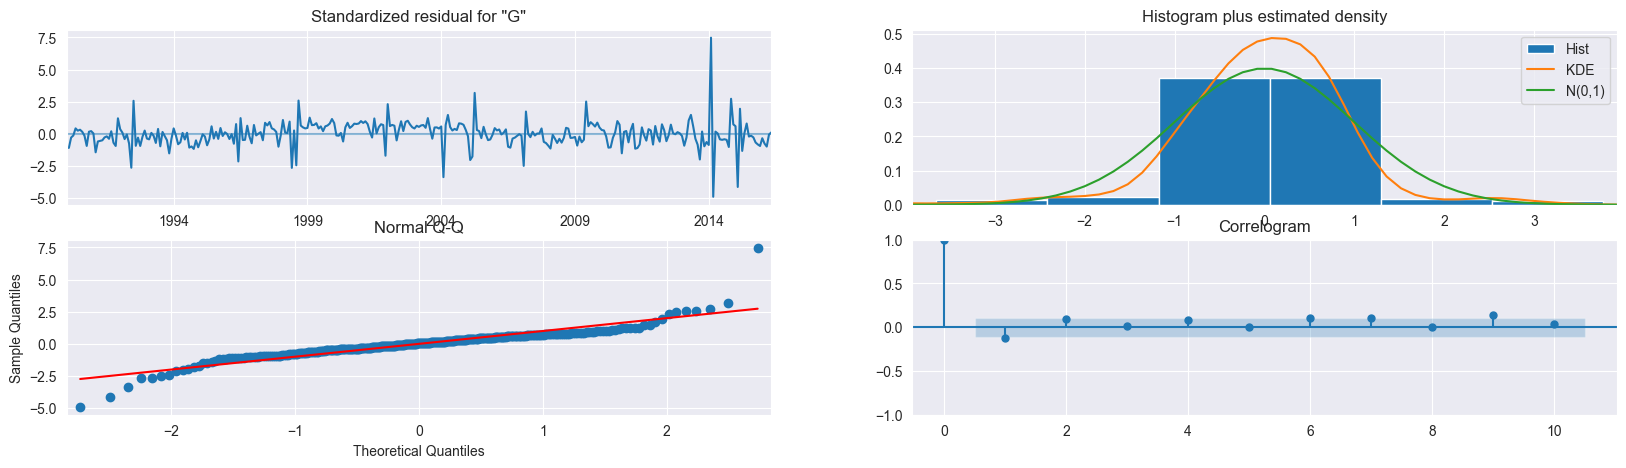

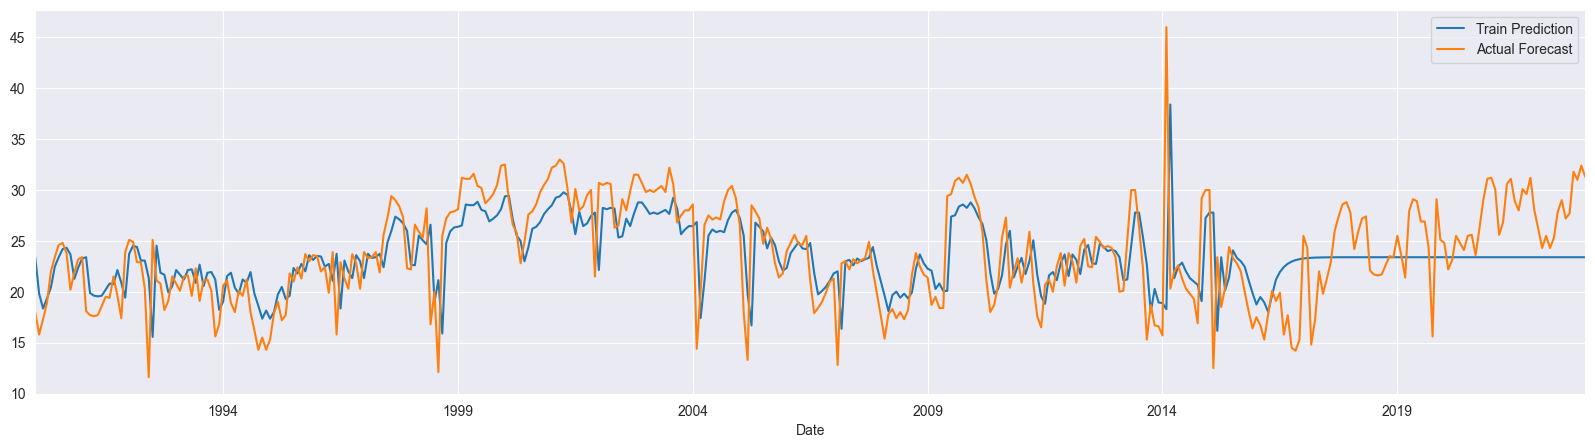

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      Electricity Consumption (MWh)   No. Observations:                  317
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 3)   Log Likelihood               -1636.833
Date:                            Thu, 10 Aug 2023   AIC                           3281.666
Time:                                    00:35:52   BIC                           3296.651
Sample:                                01-01-1990   HQIC                          3287.654
                                     - 05-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6019      0.050     11.973      0.000       0.503       0.700
ma.L1         -0.9999      4.949   

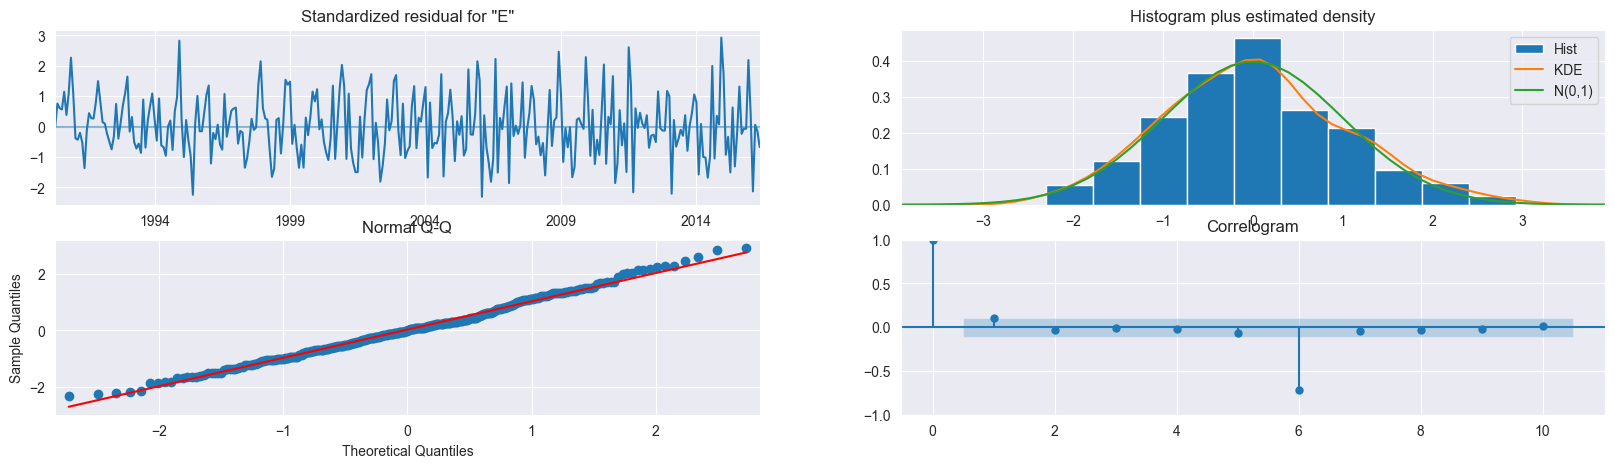

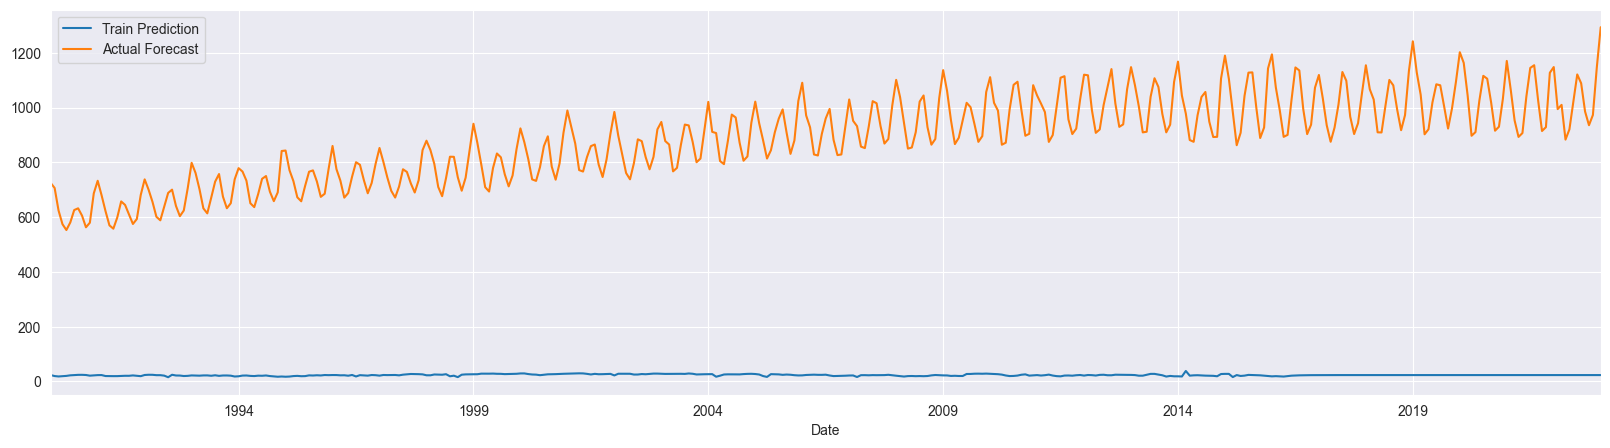

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                   
Dep. Variable:     Water Consumption (tons)   No. Observations:                  317
Model:                       ARIMA(1, 0, 1)   Log Likelihood               -1925.142
Date:                      Thu, 10 Aug 2023   AIC                           3858.285
Time:                              00:35:53   BIC                           3873.320
Sample:                          01-01-1990   HQIC                          3864.291
                               - 05-01-2016                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        483.7452     27.148     17.819      0.000     430.536     536.954
ar.L1          0.8790      0.044     19.939      0.000       0.793       0.965
ma.L

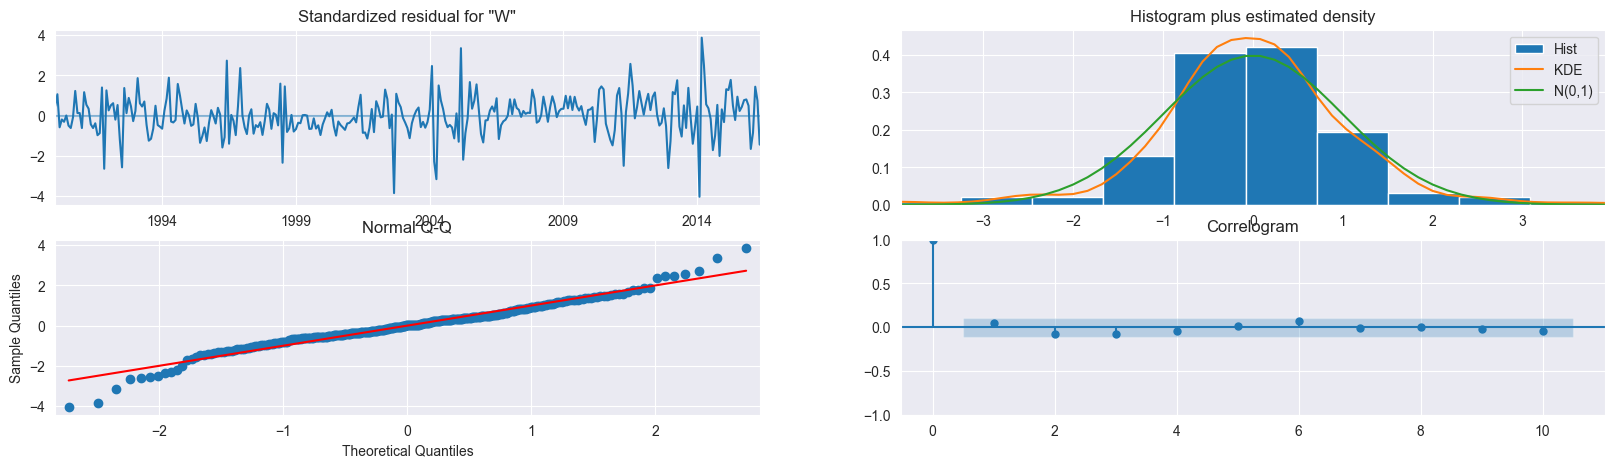

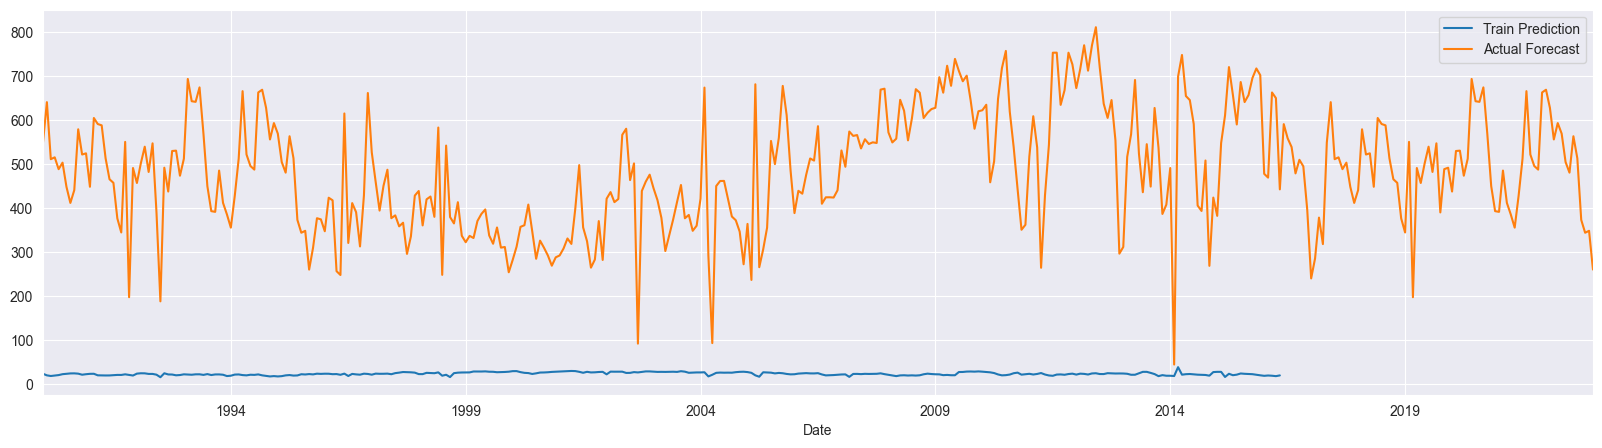

In [42]:
# Seasonal Order (P, D, Q, S)
gas_sorder = (0, 0, 0, 0) # non existent
electricity_sorder = (1, 1, 0, 3)
water_sorder = (0, 0, 0, 0) # non existent
seasonal_list = [gas_sorder, electricity_sorder, water_sorder]

# Order (p, d, q)
gas_order = (1, 0, 0)
electricity_order = (1, 1, 1)
water_order = (1, 0, 1)
order_list = [gas_order, electricity_order, water_order]

model_list = []

for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    if y_temp in ["Gas Consumption (tons)", "Water Consumption (tons)"]:
        model_list.append(ARIMA(y_train_dic[y_temp], order=order_list[i]).fit())
    else:
        model_list.append(
            SARIMAX(
                y_train_dic[y_temp],
                order=order_list[i],
                seasonal_order=seasonal_list[i],
            ).fit()
        )

    print(model_list[i].summary())
    model_list[i].plot_diagnostics()
    plt.show()

    resource_pred.append(model_list[i].predict(
        start=y_train_dic[y_temp].index[0], end=y_test_dic[y_temp].index[-1]))
    #resource_test.append(model_list[i].predict(start=y_test_dic[y_temp].index[0], end=y_test_dic[y_temp].index[-1]))

    fig = plt.figure()
    resource_pred[i].plot(label="Train Prediction")
    #resource_test[i].plot(label="SARIMAX Test Prediction")
    df[y_temp].plot(label="Actual Forecast")
    plt.legend()
    plt.show()
